In [34]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.tree import plot_tree

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

Всего в датасете, помимо предсказываемой переменной Class, еще 16 переменных. 2 переменные типа object, остальные количественные (тип float64 или int64).
Всего в датасете 17966 наблюдений

In [4]:
data.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Пропущенные значения встречаются для признаков Popularity (428), key (2014) и instrumentalness (4377).

In [5]:
data.nunique()

Artist Name            9149
Track Name            15129
Popularity              100
danceability            909
energy                 1208
key                      11
loudness               9002
mode                      2
speechiness            1194
acousticness           3930
instrumentalness       4253
liveness               1459
valence                1320
tempo                 13562
duration_in min/ms    14121
time_signature            4
Class                    11
dtype: int64

In [6]:
class_balance = data['Class'].value_counts(normalize=True)
print("Баланс классов:\n", class_balance)

Баланс классов:
 Class
10    0.275006
6     0.143754
9     0.140253
8     0.103023
5     0.080407
1     0.076295
2     0.070682
0     0.034730
7     0.032007
3     0.022338
4     0.021505
Name: proportion, dtype: float64


In [7]:
mean_value = data['Class'].value_counts().mean()
median_value = data['Class'].value_counts().median()

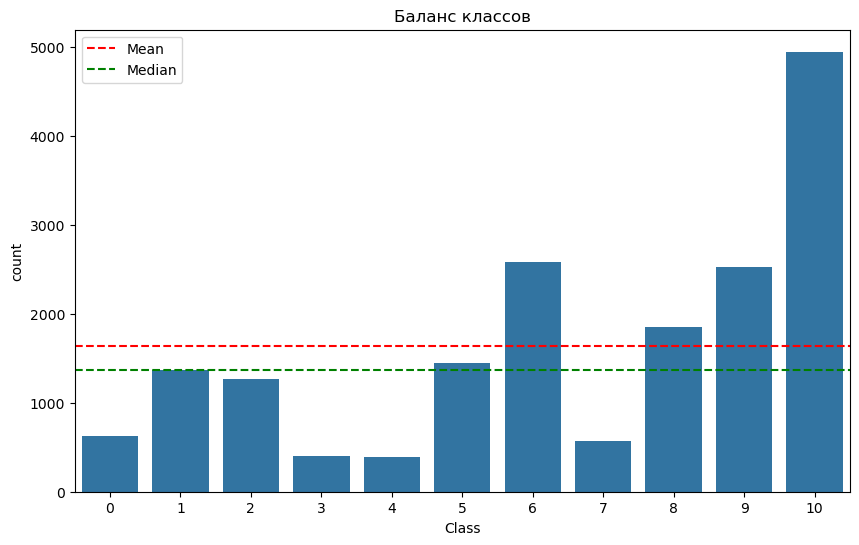

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=data)
plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean')
plt.axhline(y=median_value, color='g', linestyle='--', label='Median')
plt.title('Баланс классов')
plt.legend()
plt.show()

Видно, что классы несбалансированы. К 10 классу относится гораздо больше наблюдений (4949), чем в какому-либо еще классу. Следующие по численности после 10 класса идут 9 (2524) и 6 (2587), где наблюдений почти в 2 раза меньше. При этом самый малочисленный 4 класс содержит всего 387 наблюдения. 

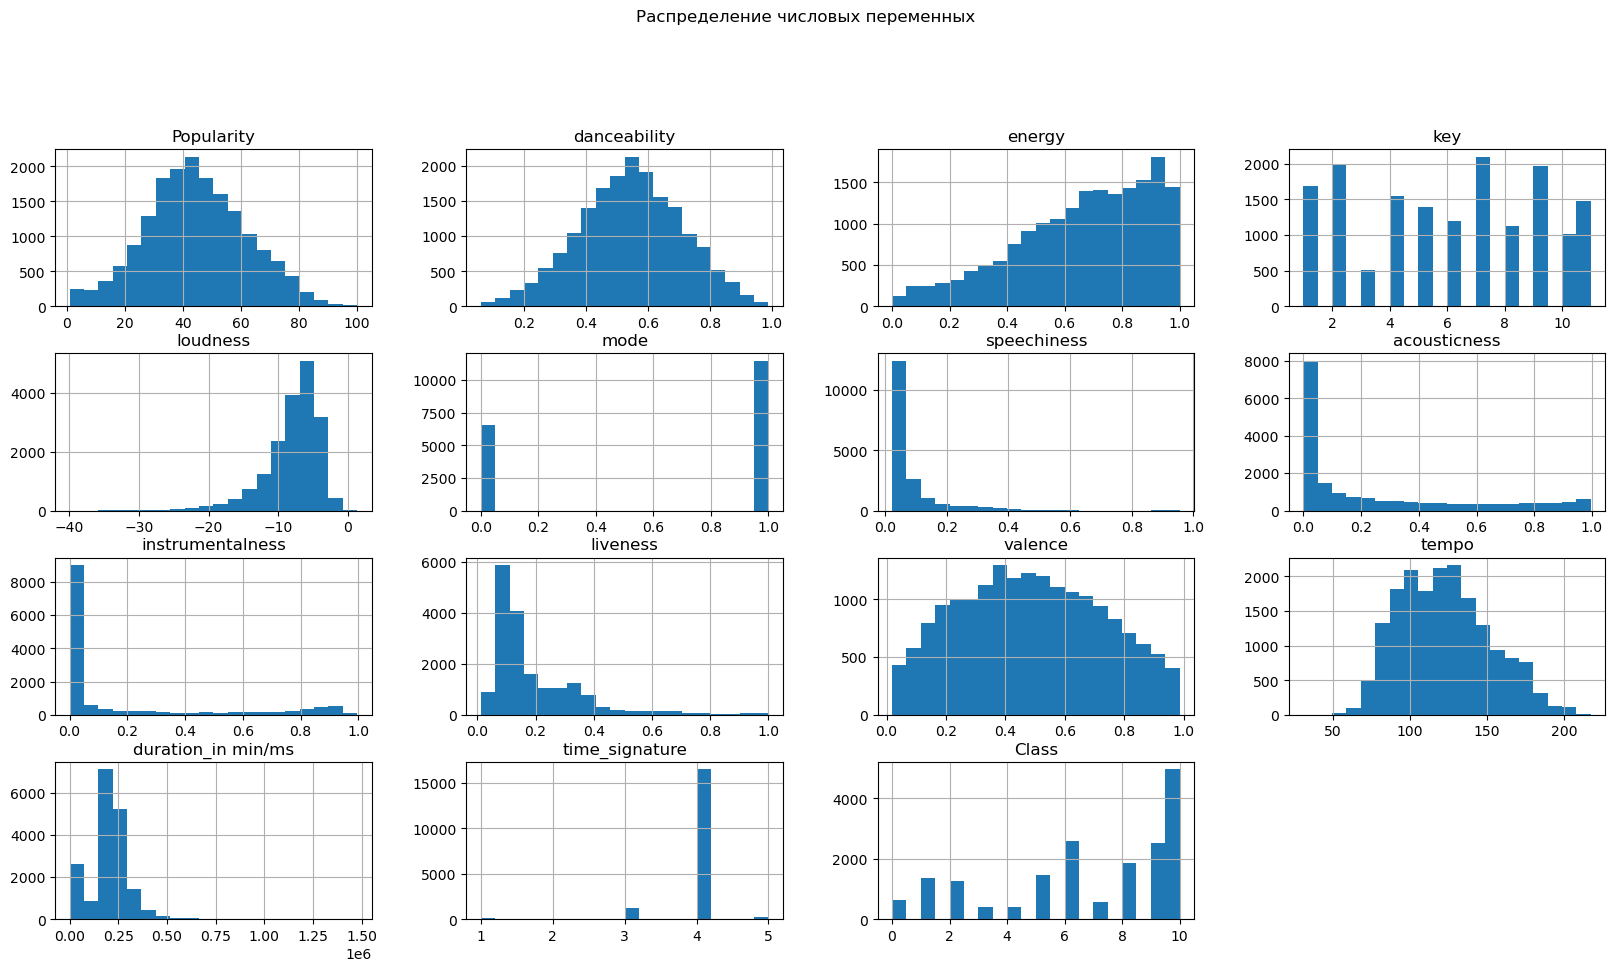

In [9]:
data.hist(figsize=(20, 10), bins=20)
plt.suptitle("Распределение числовых переменных", y=1.02)
plt.show()

Из распределения количественных переменных видно, что переменне mode, key и time_signature скорее являются факторными с 2, 11 и 4 градациями соответвтенно.

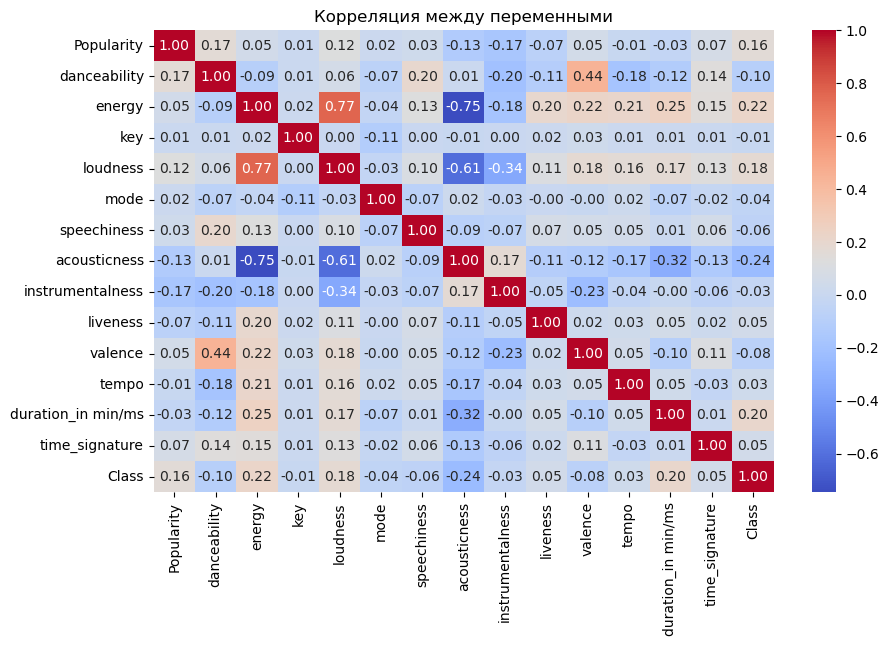

In [10]:
data_dropped_columns = data.drop(columns=['Artist Name', 'Track Name'])
plt.figure(figsize=(10, 6))
sns.heatmap(data_dropped_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между переменными')
plt.show()

**Итого**

Для последующей классификации я буду использовать все переменные, кроме Artist Name и Track Name. Пропущенные значения для Popularity, key и instrumentalness заполню средними. (Хотя наверное можно просто выкинуть эти строчки, т.к. данных без пропусков достаточно много. Или можно было бы заполнить как-то более "по-умному" с помощью knn, например).

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [23]:
X = data.drop(['Artist Name', 'Track Name', 'Class'], axis = 1)
y = data.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Замена пропущенных значений на средние
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced')) 
])

parameters = {
    'classifier__criterion': ['gini', 'entropy'], 
    'classifier__max_depth': range(1, 30),
    'classifier__min_samples_split': range(2, 6),
    'classifier__min_samples_leaf': range(2, 6)
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Лучшая оценка: 0.4156710229246266


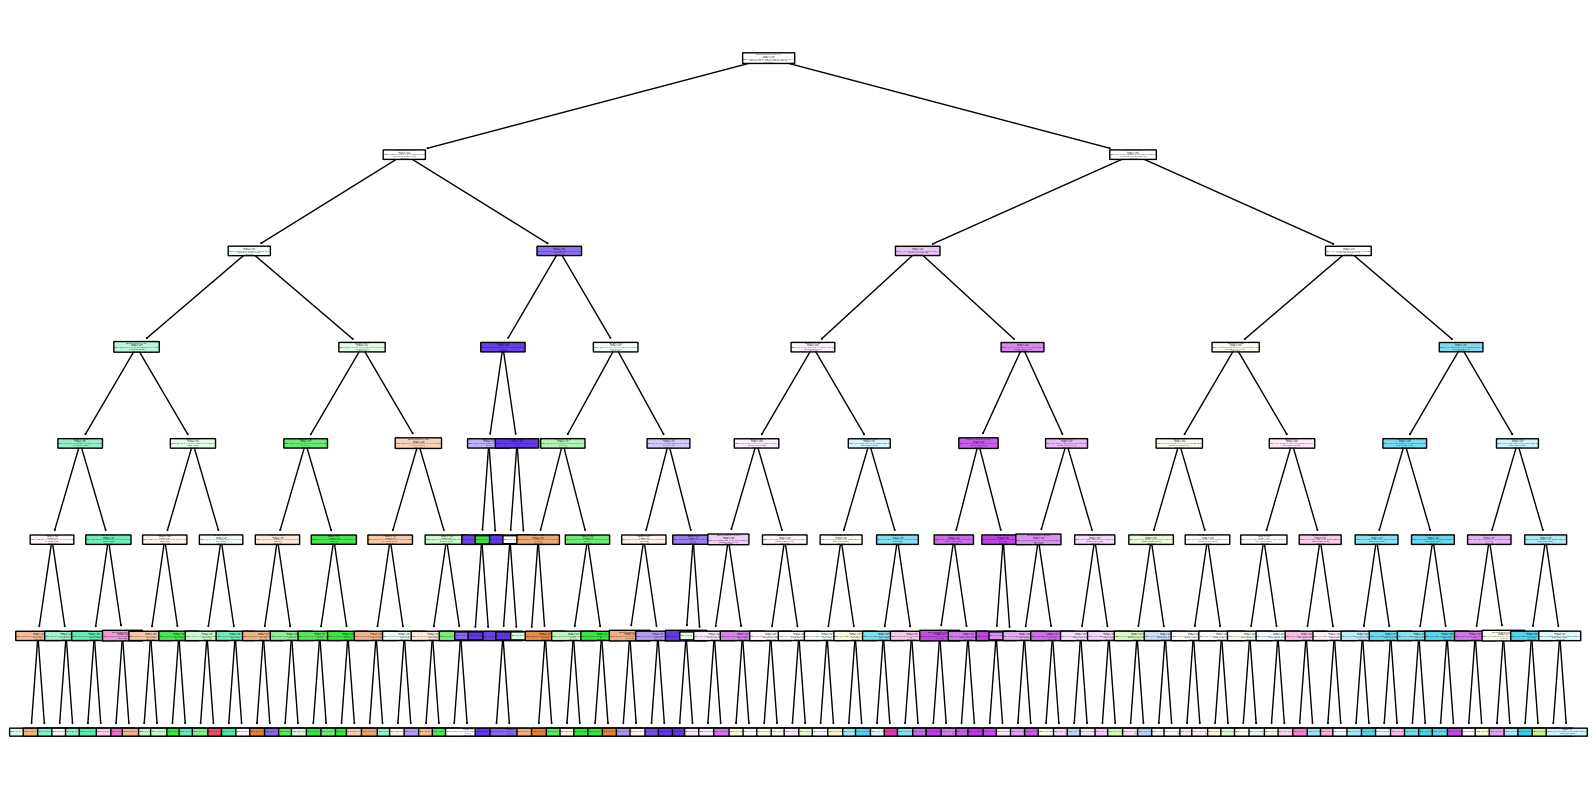

In [37]:
best_classifier = grid_search.best_estimator_['classifier']
plt.figure(figsize=(20,10))  
plot_tree(best_classifier, 
          filled=True,      # Заполнение узлов цветом в зависимости от класса
          rounded=True,     
          feature_names=X_train.columns,  # Названия признаков
          class_names=True) # Использование имен классов
plt.show()

In [38]:
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.68      0.61       136
           1       0.15      0.21      0.18       286
           2       0.25      0.49      0.33       281
           3       0.60      0.58      0.59        78
           4       0.49      0.83      0.61        71
           5       0.47      0.74      0.58       262
           6       0.39      0.10      0.16       500
           7       0.81      0.84      0.82       103
           8       0.41      0.75      0.53       382
           9       0.33      0.40      0.36       531
          10       0.49      0.15      0.23       970

    accuracy                           0.38      3600
   macro avg       0.45      0.53      0.46      3600
weighted avg       0.41      0.38      0.35      3600



In [40]:
y_prob = best_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"ROC AUC (One-vs-Rest): {roc_auc}")

ROC AUC (One-vs-Rest): 0.8478474862750592


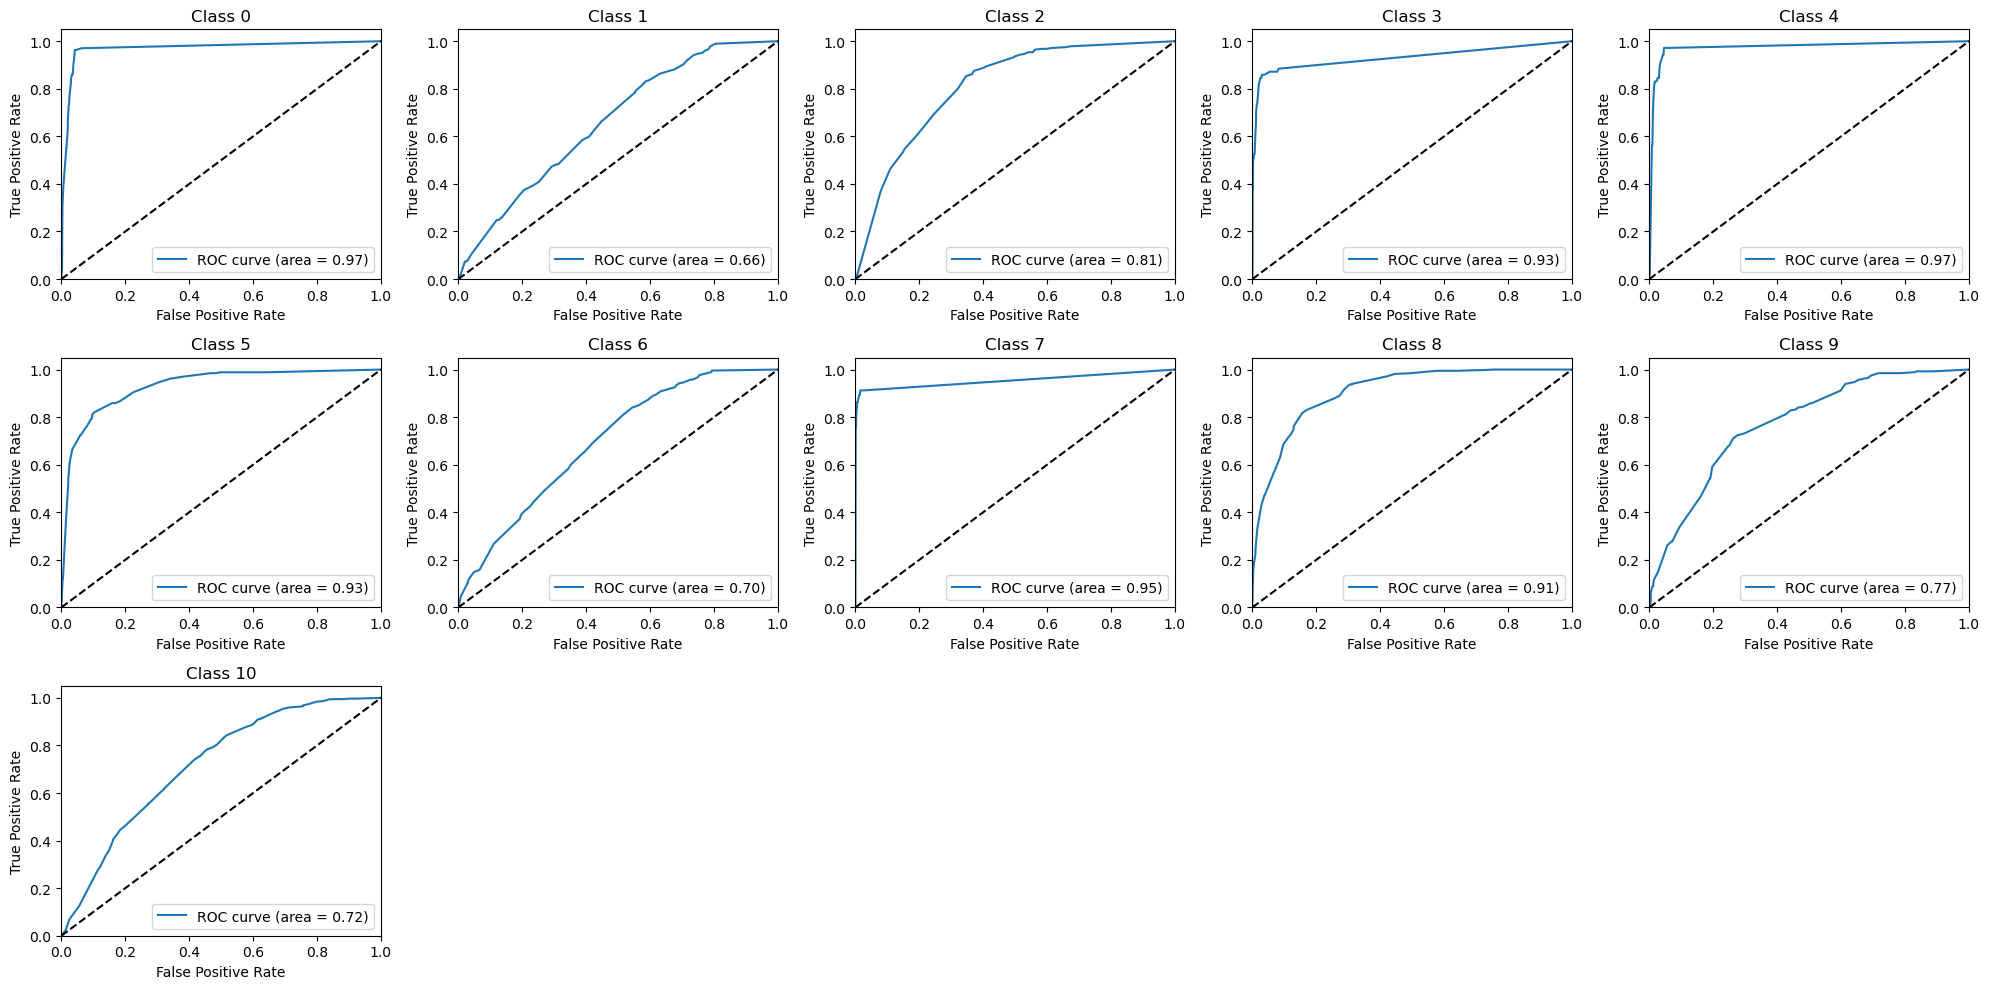

In [41]:
n_classes = len(np.unique(y_test))

# Бинаризация меток классов
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Расчет ROC кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Создание рисунка и осей с помощью subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))  # Размер рисунка задан для удобного отображения
axes = axes.ravel()  # Преобразование двумерного массива осей в одномерный

for i in range(n_classes):
    ax = axes[i]
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Class {i}')
    ax.legend(loc="lower right")

# Скрытие неиспользованных осей
for i in range(n_classes, 15):
    axes[i].axis('off')

# Показать график
plt.tight_layout()
plt.show()


**Итого**

Классы 0, 3, 4, 5, 7, и 8 имеют относительно высокие показатели точности, полноты и F1-score. Это означает, что модель довольно хорошо справляется с определением композиций, относящихся к этим музыкальным жанрам.

Класс 6 и 10 имеют низкие значения F1-score-а, особенно класс 6 еще и с очень низким recall-ом (0.10). Это говорит о том, что модель часто пропускает истинные случаи класса 6 и неправильно классифицирует их как принадлежащие к другим классам. Аналогично низкий recall (0.15) класса 10 говорит о большом количестве ложно отрицательных срабатываний для этого класса.

Класс 9 имеет средние значения по всем показателям, что говорит о средней производительности модели для этого класса.

Общая точность модели составляет 38%, что довольно низко, даже с учетом того, что классы несбаласированные, все равно низкая точность.
При этом значение средней производительности модели по всем классам ROC AUC составляет 0.847, что в целом неплохо и говорит о том, что модель в среднем неплохо различает классы между собой. 

Среднее значение (macro avg) всех метрик выше, чем взвешенное среднее (weighted avg). Это говорит о том, что модель хуже работает на классах с большим количеством образцов. И это видно на графиках: почему-то модель хуже работает на классах в высокой представленностью (10 и 6), чем с низкой представленностью, хотя скорее ожидается, что будет наоборот. Поэтому для дальнейшего улучшения модели можно как-то "поиграться" с балансировкой классов.


### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

Мультики*_*

1.Смешарики: Начало

2.Смешарики: Дежавю

3.Смешарики: 2003-2012, 2 сезона

- Если очень нужно зачилиться и отдохнуть, то мой любимый фильм - Властелин колец (все три части).

- Если комедия, то Догма (1996) или Шапито-Шоу (2011) или 1+1 (2011)
- Если трагедия (триллер/боевик), то Старикам тут не место (2007) или Джанго освобожденный (2012).

И один из моих самых любимых полнометражных мультиков -- **Большой злой лис и другие сказки (2017)**. В нем хорошо все: сюжет, анимация, персонажи. И если смотреть на французском, то будет еще в 2 раза смешнее из-за оригинальных интонаций))